# Experimental reproducibility


#### To reproduce the experiment and collect the signal from new volunteers, just use the image base and the project available in the following links.    

Link newborn image database: https://drive.google.com/drive/folders/1ZPDyR-J_2LMgeUIEoopqZYOg6t15S6eX?usp=sharing

Link project design in Tobii Studio:https://drive.google.com/drive/folders/1ZPDyR-J_2LMgeUIEoopqZYOg6t15S6eX?usp=sharing

#### To reproduce the results presented from the data collection performed in this experiment, use the available dataset and the following commands.

Link dataset: https://drive.google.com/file/d/1p-OfROfFxS5HYK-3S8Qpzqx0Xioh5DsK/view?usp=sharing

### PupilAnalysis_Pain - Data Processing
- Perform signal processing and preprocessing
    - Remove empty cells (outliers)
    - Calculate signal loss
    - Rebuild signal loss intervals (data missing)
    - Smooth the signal

### Step 0: Load Necessary Libraries

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import savgol_filter
from tqdm import tqdm
import time
from skimage import io
import seaborn as sns

### Step 1: Load the dataset

In [51]:
# Enter the path where the exported database was stored
# Put the letter r before the path to avoid misinterpretation of the backslash \
df = pd.read_csv(r"C:\Users\Pain\EscalasDor2_Data_Export.tsv", sep="\t") # Read file

### Step 2: View loaded data properties

In [3]:
# Check in which pupil there was the greatest signal loss
print("Amostras da pupila esquerda:",df.PupilLeft.count()) # Print number of valid Samples (without NaN) from the Left Pupil
print("Amostras da pupila direita:",df.PupilRight.count()) # Print number of valid Samples (without NaN) from the Right Pupil

Amostras da pupila esquerda: 9822368
Amostras da pupila direita: 9807051


In [4]:
print("Estímulos:",np.unique(df[df["MediaName"].notna()].MediaName)) # Filter NaN and print name of all stimuli

Estímulos: ['03_111418.bmp' '05_105754_110248.bmp' '05_110222.bmp'
 '06_112348_145026.bmp' '06_112553.bmp' '07_114829.bmp' '07_114907.bmp'
 '08_150034_150434.bmp' '08_150212.bmp' '09_141714.bmp'
 '09_142318_142459.bmp' '15_151515.bmp' '15_151810.bmp' '19_114838.bmp'
 '19_114922.bmp' '20_122223.bmp' '20_122527.bmp' '21_124220.bmp'
 '24_150608.bmp' '24_150657_150701.bmp' '25_103048.bmp' '25_103203.bmp'
 'cross.jpg']


In [5]:
print("Participantes:",np.unique(df.ParticipantName)) # Prints the identification of all subjects

Participantes: ['P100' 'P101' 'P102' 'P103' 'P104' 'P105' 'P106' 'P107' 'P108' 'P109'
 'P111' 'P113' 'P114' 'P116' 'P117' 'P118' 'P119' 'P120' 'P121' 'P122'
 'P123' 'P124' 'P125' 'P126' 'P133' 'P134' 'P140' 'P141' 'P142' 'P143'
 'P146' 'P148' 'P149' 'P15' 'P150' 'P151' 'P152' 'P153' 'P154' 'P155'
 'P156' 'P157' 'P158' 'P159' 'P16' 'P160' 'P161' 'P162' 'P163' 'P164'
 'P165' 'P166' 'P18' 'P20' 'P24' 'P25' 'P26' 'P27' 'P28' 'P30' 'P31' 'P33'
 'P34' 'P35' 'P36' 'P37' 'P38' 'P40' 'P41' 'P42' 'P43' 'P44' 'P45' 'P46'
 'P47' 'P48' 'P49' 'P50' 'P51' 'P52' 'P53' 'P56' 'P57' 'P58' 'P59' 'P60'
 'P61' 'P62' 'P64' 'P65' 'P66' 'P67' 'P68' 'P70' 'P72' 'P75' 'P76' 'P77'
 'P78' 'P79' 'P81' 'P82' 'P83' 'P84' 'P85' 'P86' 'P87' 'P88' 'P89' 'P90'
 'P93' 'P94' 'P99']


In [6]:
# Check if it is necessary to exclude or convert the type of some variable
print(df.info()) # Print summary of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10941826 entries, 0 to 10941825
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ParticipantName  object 
 1   MediaName        object 
 2   PupilLeft        object 
 3   PupilRight       object 
 4   Unnamed: 4       float64
dtypes: float64(1), object(4)
memory usage: 417.4+ MB
None


### Step 3: Organize and clean the dataset
- In this step, instead of excluding the data that you are not going to use, select only the data that you are going to use and overwrite the database

In [7]:
# Select only the columns you are going to user
df = df[['ParticipantName','MediaName','PupilLeft']]
# Rename the Pupil with the most recorded samples to "Pupil"
df.rename(columns = {'PupilLeft':'Pupil'}, inplace = True)
display(df)

ParticipantName MediaName Pupil
0                    P15       NaN   NaN
1                    P15       NaN   NaN
2                    P15       NaN   NaN
3                    P15       NaN   NaN
4                    P15       NaN   NaN
...                  ...       ...   ...
10941821            P166       NaN   NaN
10941822            P166       NaN   NaN
10941823            P166       NaN   NaN
10941824            P166       NaN   NaN
10941825            P166       NaN   NaN

[10941826 rows x 3 columns]

In [8]:
# List the subjects to be used (Name of the Participant associated with the Tobii Studio recording)
# P 1:44 = experts # 44
# P 45:73 = parents # 29
# P 73:102 = non_parents # 29

experts = ['P15','P33','P26','P27','P28','P31','P30','P38','P36','P75',
          'P66','P46','P48','P47','P85','P90','P83','P89','P84','P93',
          'P94','P100','P99','P103','P146','P143','P142','P141','P134','P133',
          'P124','P123','P166','P165','P164','P162','P163','P151','P148','P149',
          'P152','P153','P157','P160']
parents = ['P53','P52','P51','P49','P42','P40','P41','P35','P34','P20',
           'P86','P81','P76','P77','P87','P104','P102','P107','P120','P121',
           'P122','P114','P117','P125','P126','P155','P154','P159','P158']
# P62 removed
non_experts = ['P70','P60','P59','P58','P64','P65','P56','P57','P67',
               'P68','P45','P44','P43','P61','P16','P37','P50','P78','P88',
               'P79','P101','P105','P106','P108','P113','P118','P119','P116','P161']
p = experts + parents + non_experts

df = df[df.ParticipantName.isin(p)] # Select only participants from the list and overwrite the dataset
display(df)

ParticipantName MediaName Pupil
0                    P15       NaN   NaN
1                    P15       NaN   NaN
2                    P15       NaN   NaN
3                    P15       NaN   NaN
4                    P15       NaN   NaN
...                  ...       ...   ...
10941821            P166       NaN   NaN
10941822            P166       NaN   NaN
10941823            P166       NaN   NaN
10941824            P166       NaN   NaN
10941825            P166       NaN   NaN

[9858665 rows x 3 columns]

In [22]:
# List the MediaName to be used (Name of the media/stimuli element from the Tobii Studio test timeline)
pain = ["05_105754_110248.bmp","06_112553.bmp","07_114907.bmp","08_150212.bmp","09_142318_142459.bmp",
           "15_151810.bmp","19_114922.bmp","20_122527.bmp","24_150657_150701.bmp","25_103203.bmp"] 
painless = ["05_110222.bmp","06_112348_145026.bmp","07_114829.bmp", "08_150034_150434.bmp","09_141714.bmp",
           "15_151515.bmp","19_114838.bmp","20_122223.bmp","24_150608.bmp","25_103048.bmp"]
stimuli = pain + painless # Concatenate lists

df = df[df.MediaName.isin(stimuli)] # Select only stimuli from the list and overwrite the dataset
display(df)

ParticipantName      MediaName  Pupil
15028                P15  19_114922.bmp   3.20
15029                P15  19_114922.bmp   3.15
15030                P15  19_114922.bmp   3.05
15031                P15  19_114922.bmp   3.13
15032                P15  19_114922.bmp   3.16
...                  ...            ...    ...
10940015            P166  20_122527.bmp   3.13
10940016            P166  20_122527.bmp   3.14
10940017            P166  20_122527.bmp   3.16
10940018            P166  20_122527.bmp   3.16
10940019            P166  20_122527.bmp   3.14

[4293854 rows x 3 columns]

### Step 4: Fix data type and format

In [10]:
df["Pupil"] = df["Pupil"].replace(",",".", regex=True) # Replace comma with dot, use regex parameter to apply to df 
df["Pupil"] = pd.to_numeric(df["Pupil"]) # Convert data type to numeric (Float)
display(df)

ParticipantName      MediaName  Pupil
15028                P15  19_114922.bmp   3.20
15029                P15  19_114922.bmp   3.15
15030                P15  19_114922.bmp   3.05
15031                P15  19_114922.bmp   3.13
15032                P15  19_114922.bmp   3.16
...                  ...            ...    ...
10940015            P166  20_122527.bmp   3.13
10940016            P166  20_122527.bmp   3.14
10940017            P166  20_122527.bmp   3.16
10940018            P166  20_122527.bmp   3.16
10940019            P166  20_122527.bmp   3.14

[4293854 rows x 3 columns]

### Step 5: Analyze signal loss by participant
- Commonly, the criterion of 70% of valid samples is used
    - Check if the signal acquisition rate is equal to or higher than the stipulated criterion
    - Remove participants with acquisition rate below the criteria

In [11]:
lista1 = []; lista2 = []; lista3 = []  # Declare lists to store the amount of samples
# Loop repeat to list all participants
for i in p:
    dfi = df["ParticipantName"]==i # Filter the participant
    lista1.append(len(df[dfi])) # Filter all samples of the participant
    lista2.append(len(df[dfi][df[dfi]["Pupil"].notna()])) # Filter only samples recorded, without NaN
    lista3.append(len(df[dfi][df[dfi]["Pupil"].notna()])/len(df[dfi])) # Calculate rec rate
report = pd.DataFrame(data={'AllSamples':lista1,'ValidSamples':lista2,'RecRate':lista3}, index=[p]) # Create Report
display(report) 

AllSamples  ValidSamples   RecRate
P15        42095         41861  0.994441
P33        42099         40013  0.950450
P26        42096         38886  0.923746
P27        42098         40816  0.969547
P28        42094         40075  0.952036
...          ...           ...       ...
P113       42097         36495  0.866926
P118       42095         38085  0.904739
P119       42098         41279  0.980545
P116       42096         29732  0.706290
P161       42098         41322  0.981567

[102 rows x 3 columns]

In [12]:
# Check if there is any participant with acquisition rate below the criteria
criterio = 0.7 # Define criteria (normally 70% is used)
dfc = report['RecRate'] < criterio 
display(report[dfc])
# If you need to remove a participant, edit the 2nd part of step 3

Empty DataFrame
Columns: [AllSamples, ValidSamples, RecRate]
Index: []

### Step 6 - Data processing
- Outlier removal
- Reconstruction of signal loss intervals (missing data)
- Signal smoothing to remove noise
- Data normalization (change)

In [13]:
# Replace outliers to NaN
factor = 0.04 # Define a filter factor for outliers
df2 = pd.DataFrame(columns=['ParticipantName','MediaName','Pupil']) # Declare an auxiliary DataFrame

for k in tqdm(range(0,len(p))):
    for j in range(0,len(stimuli)):
        dftemp = df.loc[(df["ParticipantName"]==p[k])&(df["MediaName"]==stimuli[j])] # Filter participant and stimuli
        # Check if there is a difference between samples larger than the factor or if the sample is NaN (in ascending order)
        for i in range(0,len(dftemp)-1):
            dif = abs(dftemp.iat[i,2]-dftemp.iat[i+1,2])
            if dif > factor or math.isnan(dif):
                dftemp.iat[i,2] = np.nan
        # Check if there is a difference between samples larger than the factor or if the sample is NaN (in descending order)  
        for i in range(len(dftemp)-1,0,-1):
            dif = abs(dftemp.iat[i,2]-dftemp.iat[i-1,2])
            if dif > factor or math.isnan(dif):
                dftemp.iat[i,2] = np.nan       
        # Perform signal reconstruction by linear interpolation
        interpolated = dftemp.loc[:,'Pupil'].interpolate(method='linear', limit_direction='both') 
        smoothed = savgol_filter(interpolated, 15, 3) # Smooth the signal to remove noise
        change = smoothed-smoothed[0] # Normalize data variation (change)
        for i in range(0,len(dftemp)-1):
            dftemp.iat[i,2] = change[i] 
        df2 = pd.concat([df2,dftemp.iloc[0:2100,0:3]]) # Add base signal treated in auxiliary DataFrame

100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [36:09<00:00, 21.27s/it]


### Step 7 - Visual analysis of the result

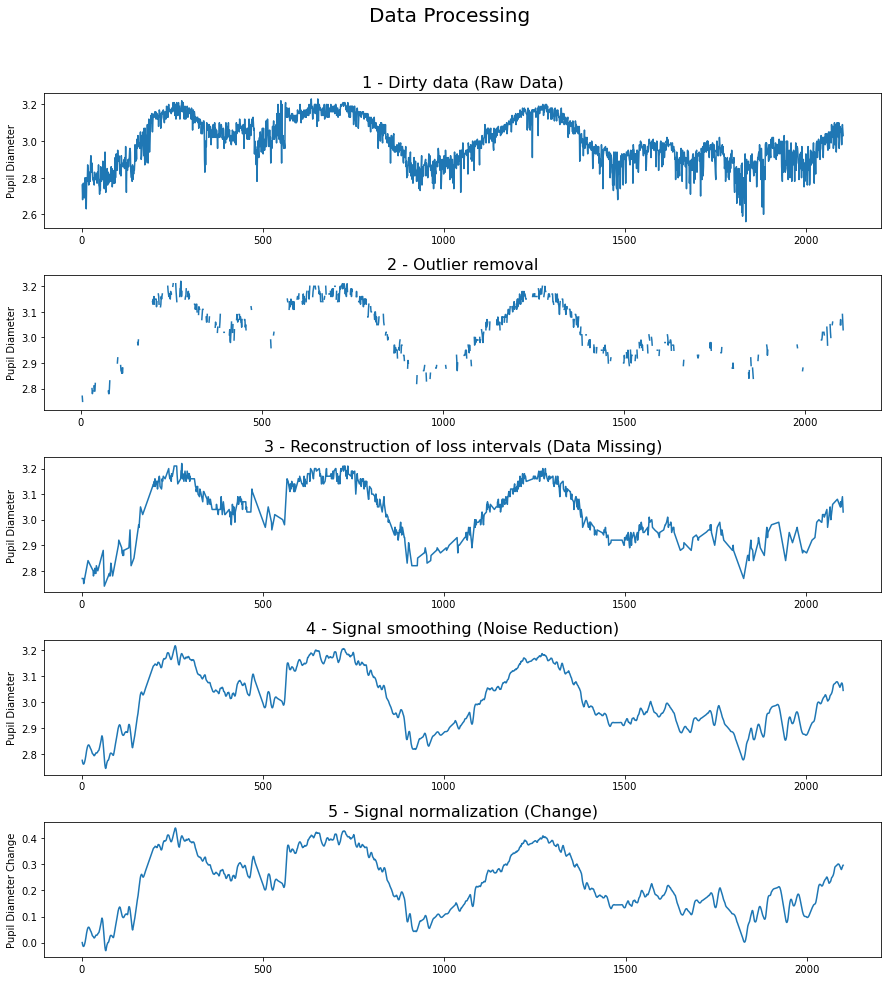

In [14]:
plt.figure(figsize = (15, 15)) # Set plot area

# Dirty Data
dftemp = df.loc[(df["ParticipantName"]==p[0])&(df["MediaName"]==stimuli[1])] # Filter participant and stimulus
x = list(range(1,len(dftemp['Pupil'])+1)) # Set the abscissa axis
y = dftemp["Pupil"] # Print untreated data
plt.subplot(5, 1, 1)
plt.plot(x,y)
plt.title("1 - Dirty data (Raw Data)", fontsize = 16)
plt.ylabel('Pupil Diameter')

# Removal of Outliers
factor = 0.04 # Define a filter factor for outliers
for i in range(0,len(dftemp)-1):
    dif = abs(dftemp.iat[i,2]-dftemp.iat[i+1,2])
    if dif > factor or math.isnan(dif):
        dftemp.iat[i,2] = np.nan
# Check if there is a difference between samples larger than the factor or if the sample is NaN (in descending order) 
for i in range(len(dftemp)-1,0,-1):
    dif = abs(dftemp.iat[i,2]-dftemp.iat[i-1,2])
    if dif > factor or math.isnan(dif):
        dftemp.iat[i,2] = np.nan
                
y = dftemp["Pupil"] # Print data without Outliers
plt.subplot(5, 1, 2)
plt.plot(x,y)
plt.title("2 - Outlier removal", fontsize = 16)
plt.ylabel('Pupil Diameter')

# Perform signal reconstruction by linear interpolation
y = dftemp.loc[:,'Pupil'].interpolate(method='linear', limit_direction='both') 
plt.subplot(5, 1, 3)
plt.plot(x,y)
plt.title("3 - Reconstruction of loss intervals (Data Missing)", fontsize = 16)
plt.ylabel('Pupil Diameter')

y = savgol_filter(y, 15, 3) # Smooth the signal to remove noise
x = list(range(1,len(y)+1))
plt.subplot(5, 1, 4)
plt.plot(x,y)
plt.title("4 - Signal smoothing (Noise Reduction)", fontsize = 16)
plt.ylabel('Pupil Diameter')

# Data after all treatment steps
y = df2.loc[(df["ParticipantName"]==p[0])&(df2["MediaName"]==stimuli[1])] # Filter participant and stimulus
x = list(range(1,len(y['Pupil'])+1)) # Set the abscissa axis
plt.subplot(5, 1, 5)
plt.plot(x,y['Pupil'])
plt.title("5 - Signal normalization (Change)", fontsize = 16)
plt.ylabel('Pupil Diameter Change')

plt.suptitle("Data Processing", fontsize = 20)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.35)
plt.show()

## PupilAnalysis_Pain - Data visualization
- Organize variables of the pupil sign
- Visualize each subject's pupil sign
- Calculate average signal by class
- View average signal by class
- View pupil sign by stimulus
- Analyze the particularities of the pupil sign

### Step 8: Configure functions to generate results

In [15]:
# Function to calculate mean sign by class
def sign_class(classe,id):
    z = np.zeros(shape=(len(classe), 2100)) # preallocates space to store pupil sign 
    k = 0 # Start counter
    for i in classe:
        w = df2.loc[(df2["ParticipantName"]==i)&(df2["MediaName"]==id)] # Filter subject and stimulus
        z[k,:]=w['Pupil'] # Store subject's sign 
        k = k+1 # Increment counter
    y = np.mean(z, axis=0) # Calculate the class mean
    x = list(range(1,len(y)+1)) # Set the abscissa axis
    g = plt.plot(x,y) # Print mean sign
    return g

In [24]:
# Function to calculate mean sign by class and by stimulus
def sign_class_cat(classe,stimuli):
    z = np.zeros(shape=(len(classe)*len(stimuli), 2100)) # preallocates space to store pupil sign 
    k = 0 # Start counter
    for i in classe:
        for j in stimuli:
            w = df2.loc[(df2["ParticipantName"]==i)&(df2["MediaName"]==j)] # Filter subject and stimulus
            z[k,:]=w['Pupil'] # Store subject's sign
            k = k+1 # Increment counter
    y = np.mean(z, axis=0) # Calculate the class mean  
    x = list(range(1,len(y)+1)) # Set the abscissa axis
    return y

In [16]:
# Function to print original image (stimuli), sign of each subject and mean sign by class
def result_id(id):
    plt.figure(figsize=(15,10)) # Set plot area
    
    plt.subplot(2,2,1) # Set position of subplot
    plt.imshow(io.imread(id)) # Print orriginal imagem
    plt.title('id: ' + id, fontsize=13, loc='left') # Set title
    plt.axis('off') # Remove axis
    
    plt.subplot(2,2,3) # Set position of subplot
    for i in p:
        y = df2.loc[(df2["ParticipantName"]==i)&(df2["MediaName"]==id)] # Filter the subjects and stimuli
        x = list(range(1,len(y['Pupil'])+1)) # Set the abscissa axis
        plt.plot(x,y['Pupil']) # Set subject's pupil sign
    plt.title("Pupil sign of all subjects", fontsize = 15) # Insert title
    plt.ylabel('Pupil Diameter Change (mm)') # Insert label of the ordinate axis
    
    plt.subplot(2,2,4) # Set position of subplot
    sign_class(experts,id) # Print mean sign by class - Experts
    sign_class(parents,id) # Print mean sign by class - Parents
    sign_class(non_experts,id) # Print mean sign by class - Non_Experts
    plt.legend(['Experts','Parents','Non_Experts']) # Insert legend
    plt.title("Mean of pupil sign by class ", fontsize = 15) # Insert title
    plt.ylabel('Pupil Diameter Change (mm)') # Insert label of the ordinate axis
    return

### Step 9: View characteristics of the pupil sign

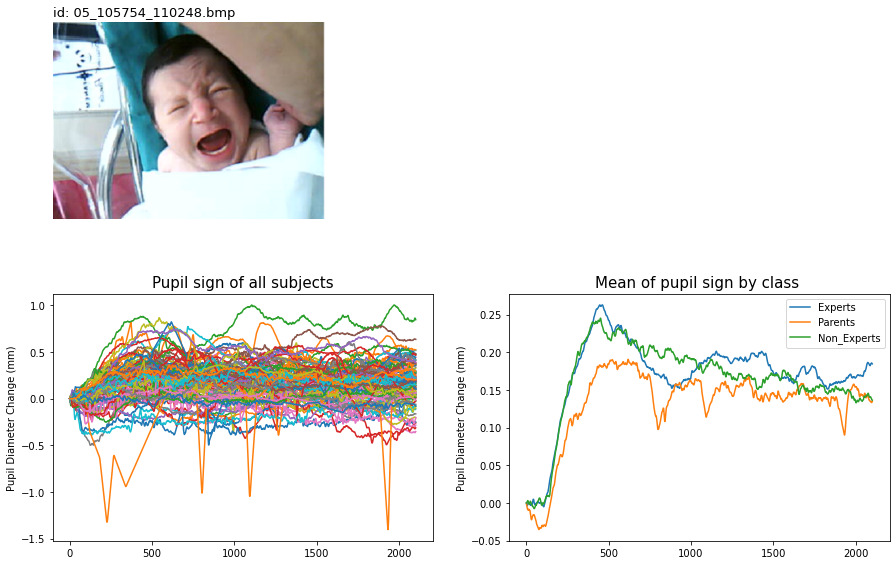

In [19]:
result_id(stimuli[0]) # Pain

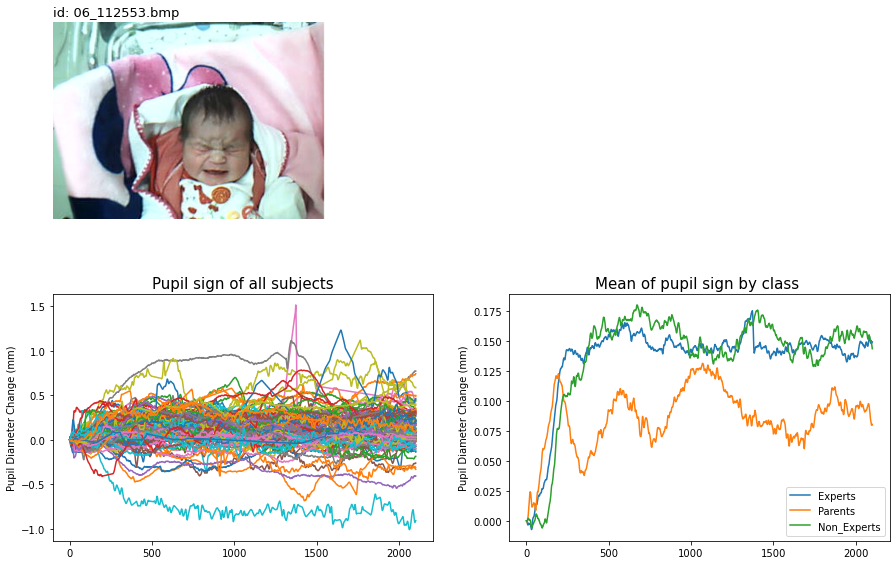

In [30]:
result_id(stimuli[1]) # Pain

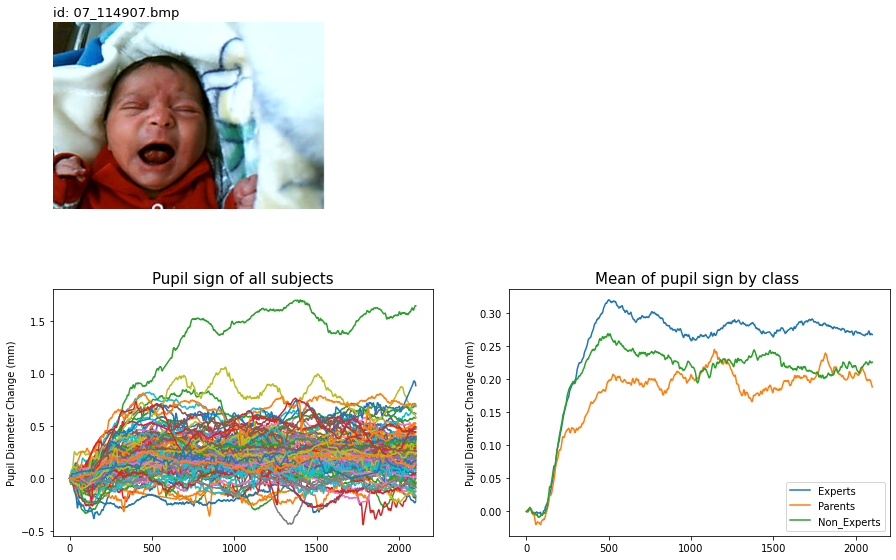

In [31]:
result_id(stimuli[2]) # Pain

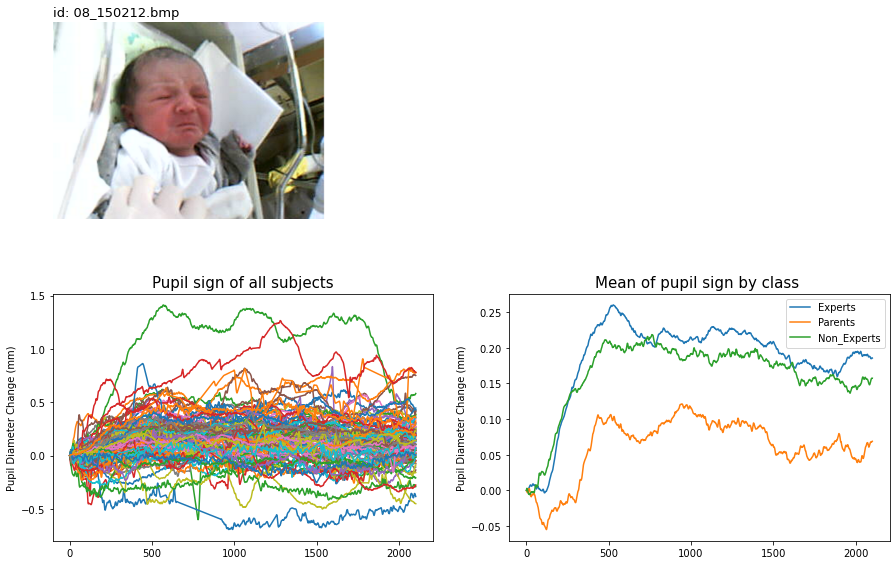

In [32]:
result_id(stimuli[3]) # Pain

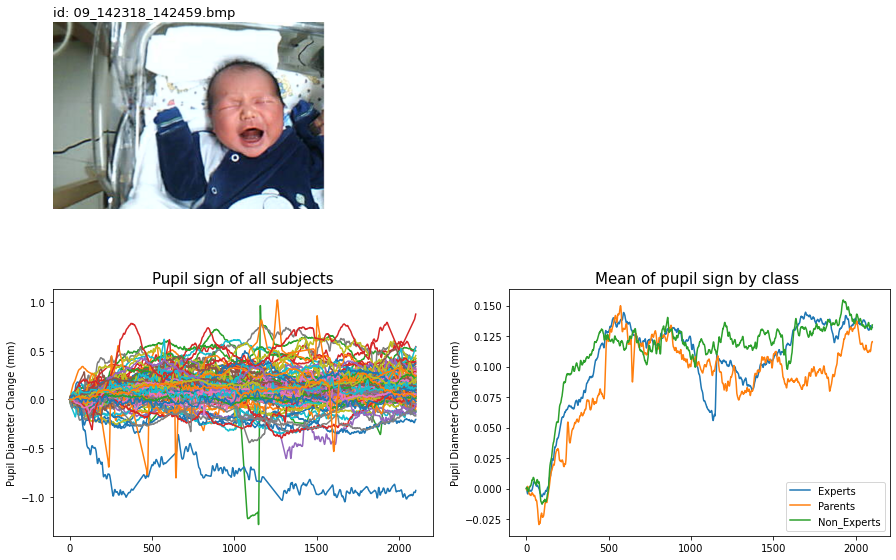

In [33]:
result_id(stimuli[4]) # Pain

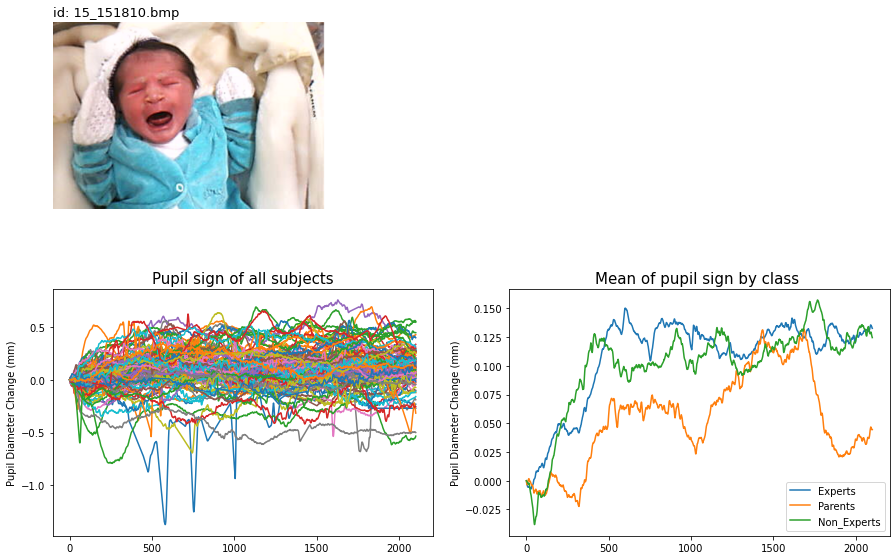

In [34]:
result_id(stimuli[5]) # Pain

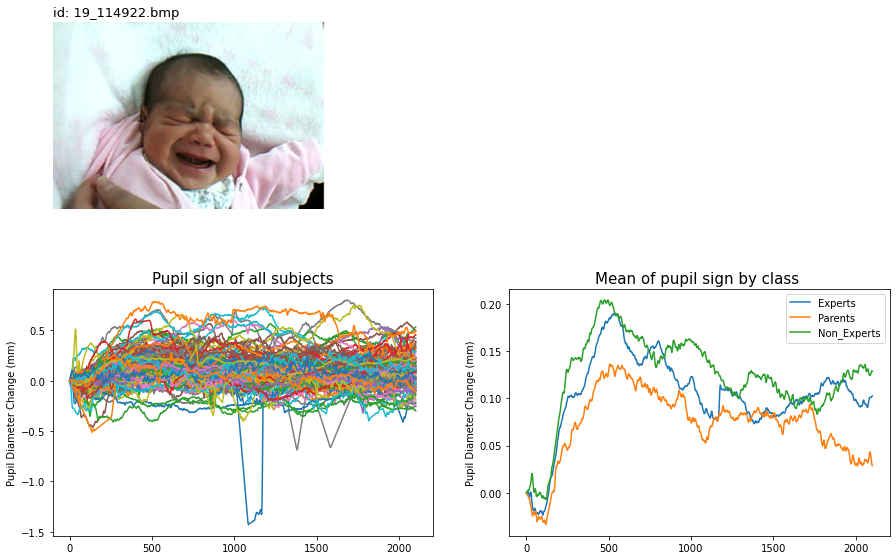

In [35]:
result_id(stimuli[6]) # Pain

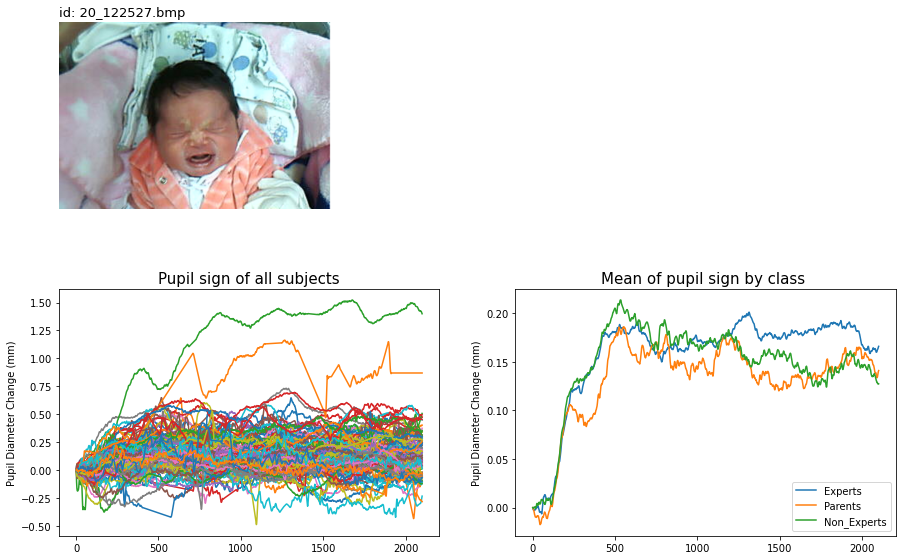

In [36]:
result_id(stimuli[7]) # Pain

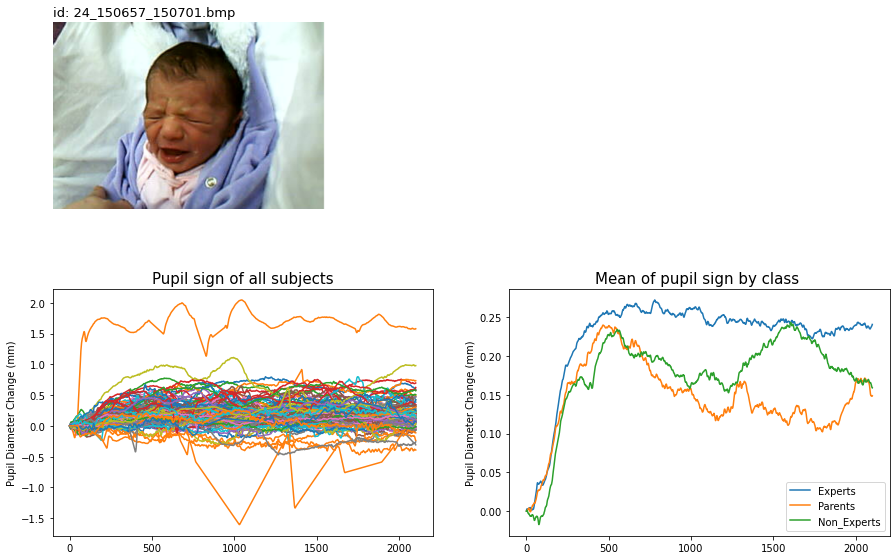

In [37]:
result_id(stimuli[8]) # Pain

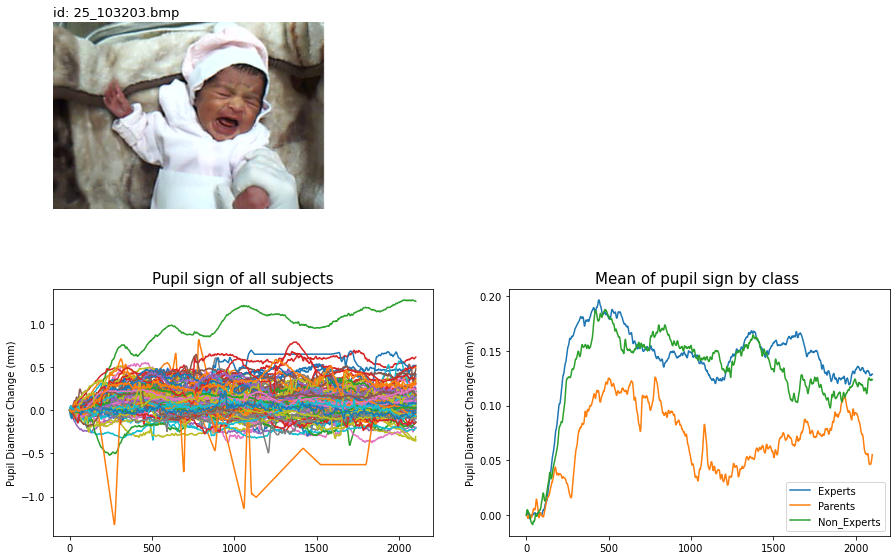

In [38]:
result_id(stimuli[9]) # Pain

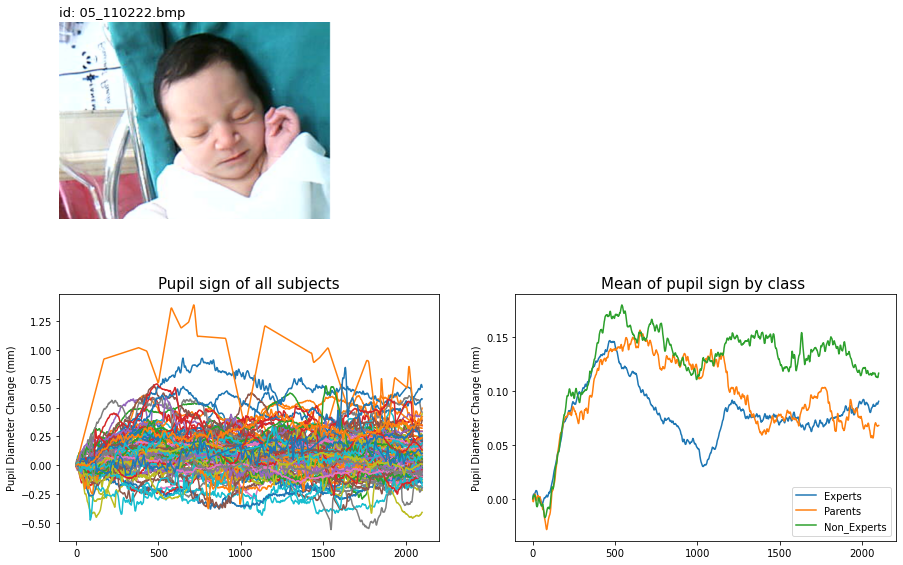

In [39]:
result_id(stimuli[10]) # Pain

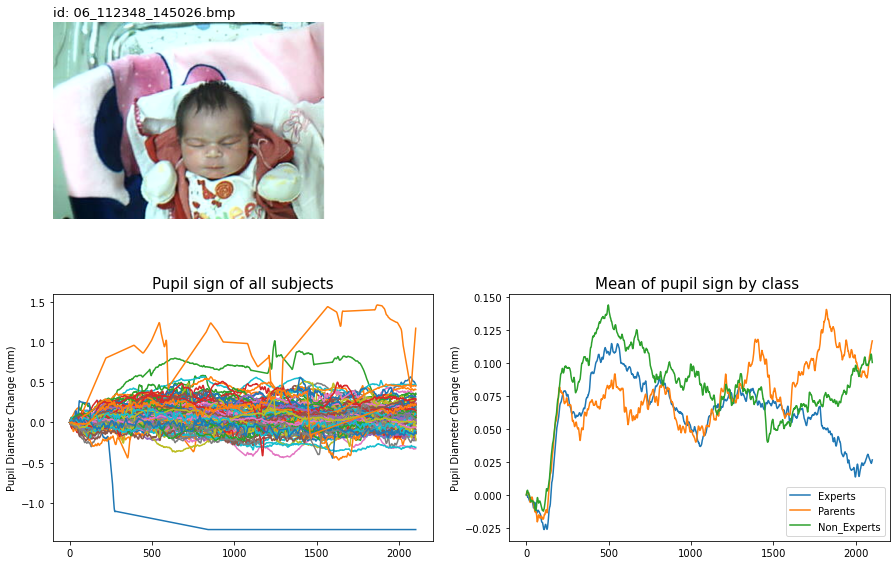

In [40]:
result_id(stimuli[11]) # Painless

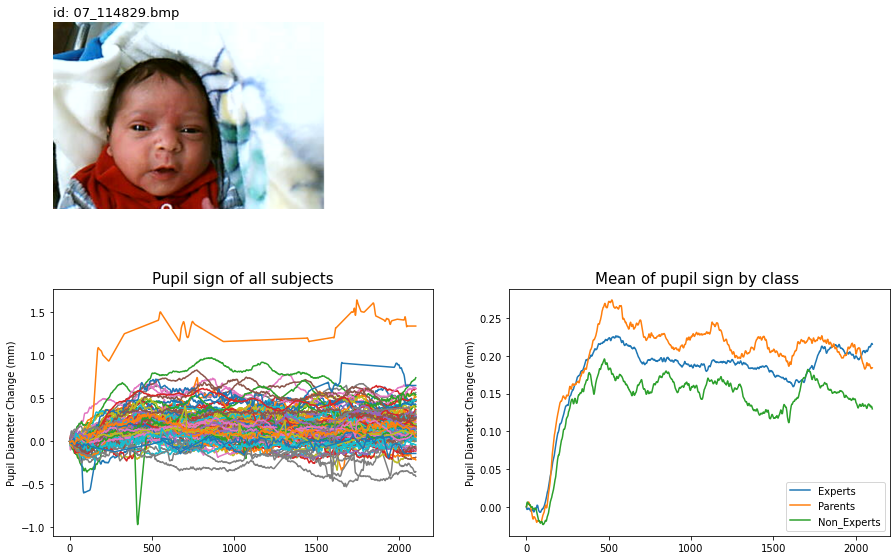

In [41]:
result_id(stimuli[12]) # Painless

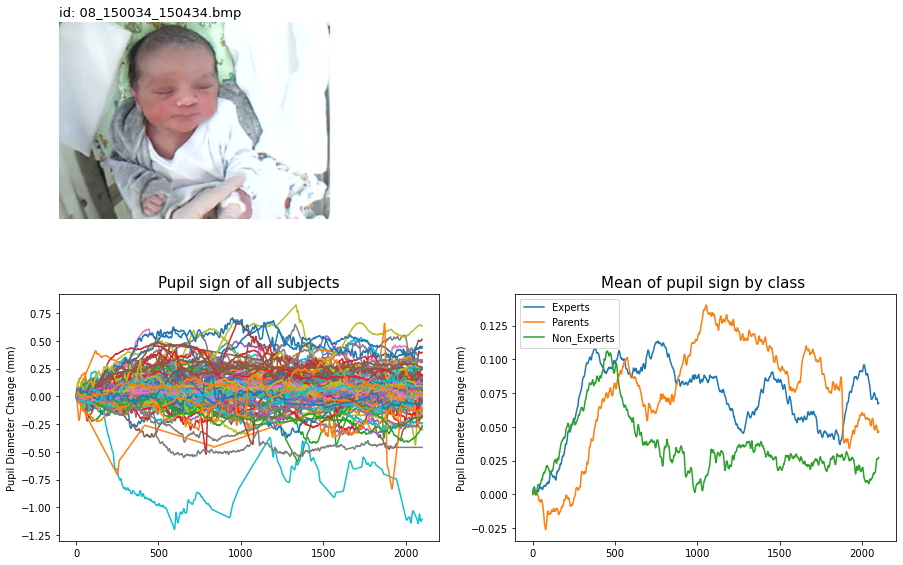

In [42]:
result_id(stimuli[13]) # Painless

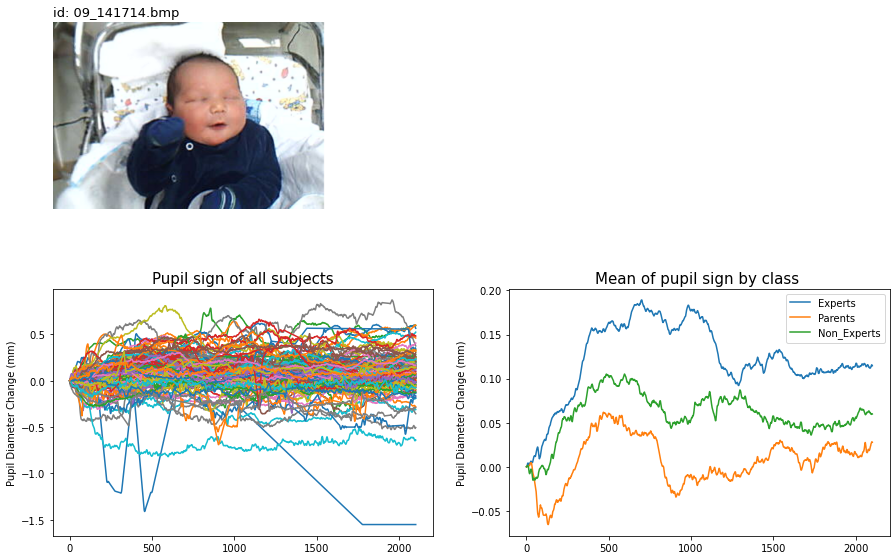

In [43]:
result_id(stimuli[14]) # Painless

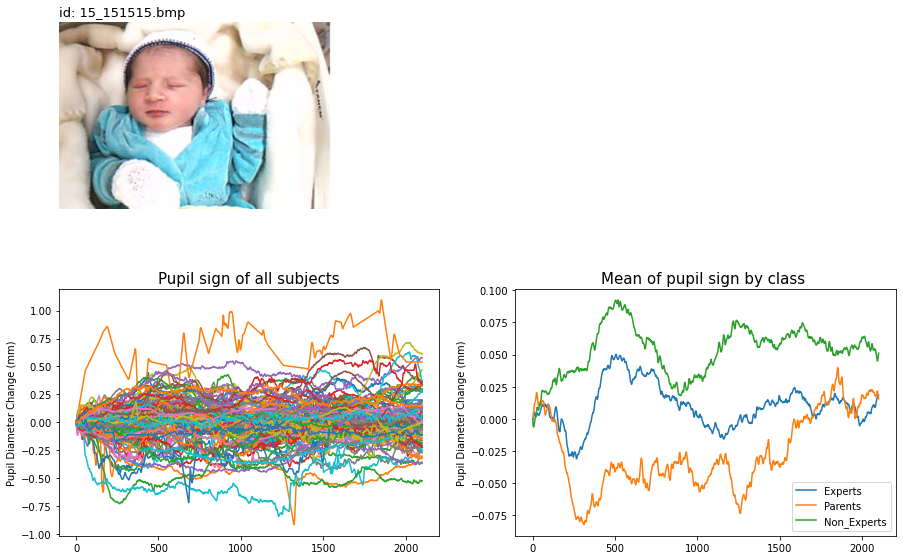

In [44]:
result_id(stimuli[15]) # Painless

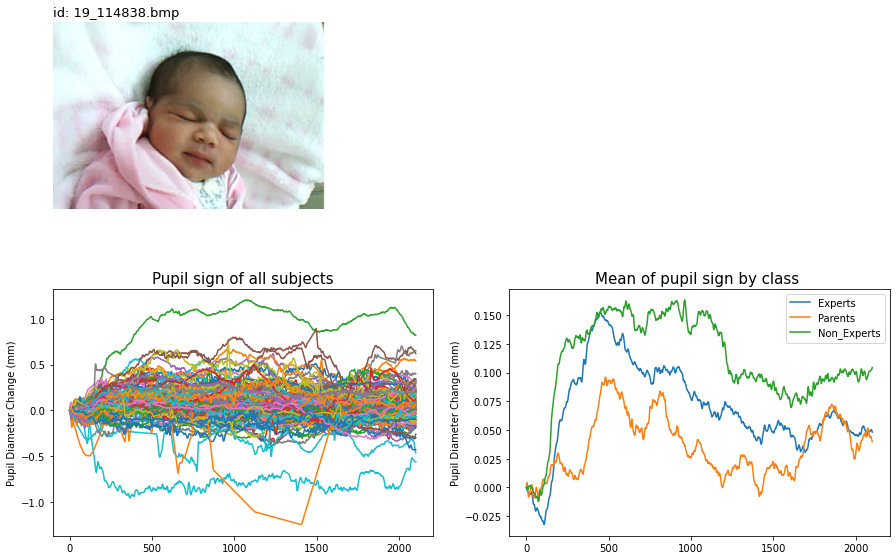

In [45]:
result_id(stimuli[16]) # Painless

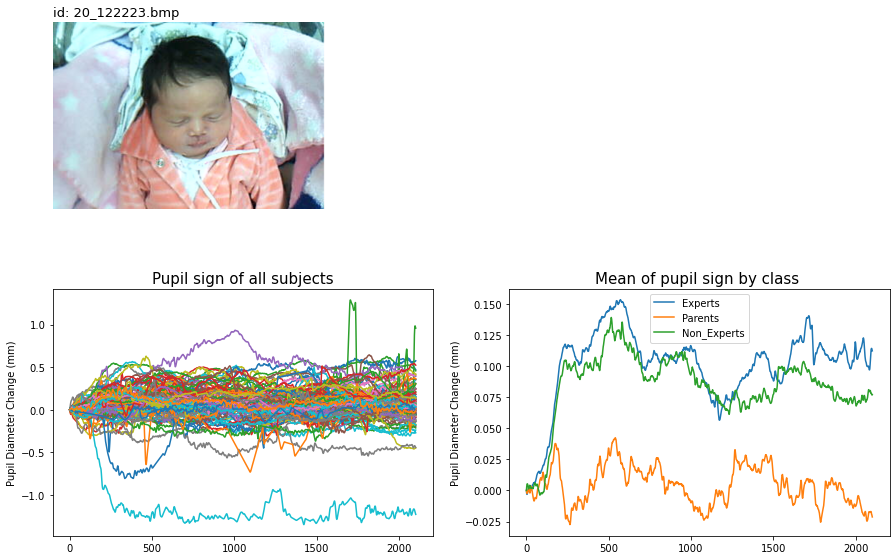

In [46]:
result_id(stimuli[17]) # Painless

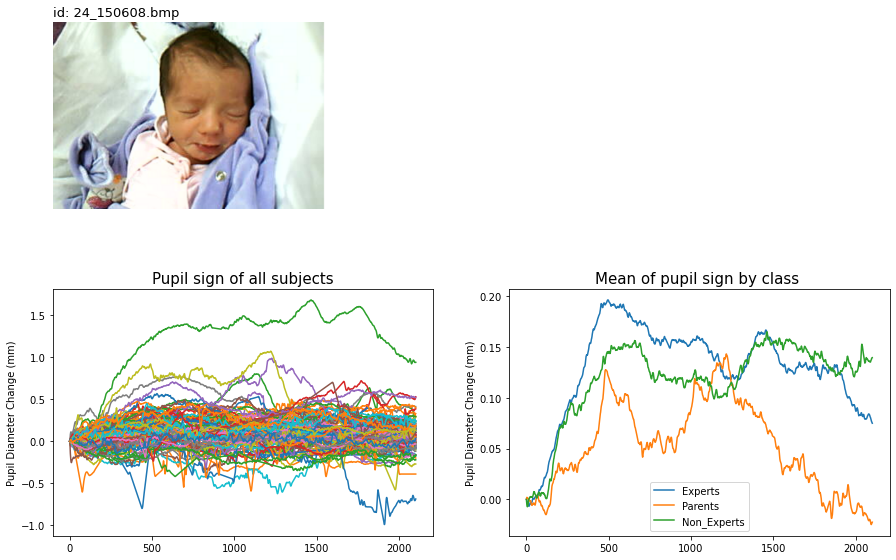

In [47]:
result_id(stimuli[18]) # Painless

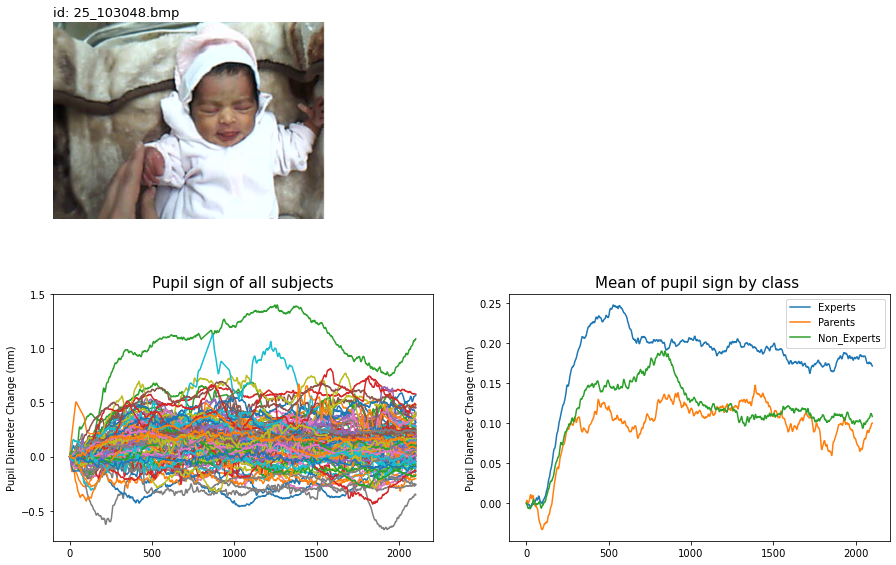

In [48]:
result_id(stimuli[19]) # Painless

In [25]:
# Get sign by class and type of stimulus
e_p = sign_class_cat(experts,pain)
e_pl = sign_class_cat(experts,painless)
p_p = sign_class_cat(parents,pain)
p_pl = sign_class_cat(parents,painless)
n_p = sign_class_cat(non_experts,pain)
n_pl = sign_class_cat(non_experts,painless)

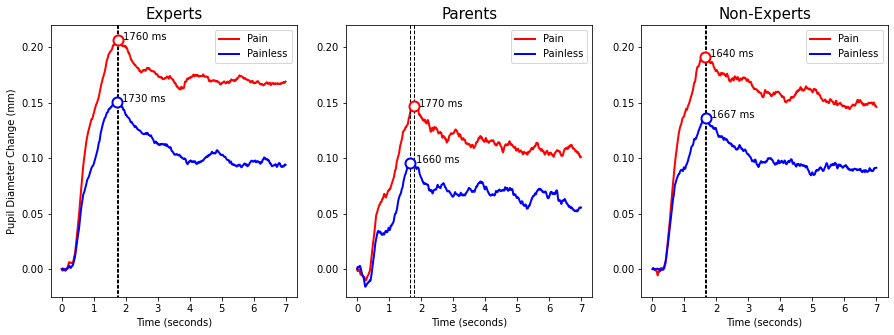

In [172]:
plt.figure(figsize=(15,5)) # Set plot area
plt.subplot(1,3,1) # Set position of subplot
x = list(range(1,len(e_p)+1)) # Set the abscissa axis
g = plt.plot(x,e_p,'r',linewidth = 2) # Print mean sign
g = plt.plot(x,e_pl,'b',linewidth = 2) # Print mean sign
g = plt.axvline(x = [np.argmax(e_p)], ymin = -0.025, ymax = 1, color = 'black', linestyle = '--', linewidth = 1)
g = plt.axvline(x = [np.argmax(e_pl)], ymin = -0.025, ymax = 1, color = 'black', linestyle = '--', linewidth = 1)
g = plt.text(x[np.argmax(e_p)]+50, e_p[np.argmax(e_p)], str(round(np.argmax(e_p)/300*1000))+str(' ms'), fontsize=10)
g = plt.text(x[np.argmax(e_pl)]+50, e_pl[np.argmax(e_pl)], str(round(np.argmax(e_pl)/300*1000))+str(' ms'), fontsize=10)
g = plt.plot(x[np.argmax(e_p)], e_p[np.argmax(e_p)], 'o', 
             markersize=10, markeredgecolor="red", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmax(e_pl)], e_pl[np.argmax(e_pl)], 'o',
             markersize=10, markeredgecolor="blue", markerfacecolor="white", markeredgewidth=2)
g = plt.ylim(-0.025, 0.22)
g = plt.legend(['Pain','Painless']) # Insert legend
g = plt.title("Experts", fontsize = 15) # Insert title
g = plt.ylabel('Pupil Diameter Change (mm)') # Insert label of the ordinate axis
g = plt.xlabel('Time (seconds)') # Insert label of the ordinate axis
g = plt.xticks(ticks=[0,300,600,900,1200,1500,1800,2100], labels=[0,1,2,3,4,5,6,7])

plt.subplot(1,3,2) # Set position of subplot
x = list(range(1,len(p_p)+1)) # Set the abscissa axis
g = plt.plot(x,p_p,'r',linewidth = 2) # Print mean sign
g = plt.plot(x,p_pl,'b',linewidth = 2) # Print mean sign
g = plt.axvline(x = [np.argmax(p_p)], ymin = -0.025, ymax = 1, color = 'black', linestyle = '--', linewidth = 1)
g = plt.axvline(x = [np.argmax(p_pl)], ymin = -0.025, ymax = 1, color = 'black', linestyle = '--', linewidth = 1)
g = plt.text(x[np.argmax(p_p)]+50, p_p[np.argmax(p_p)], str(round(np.argmax(p_p)/300*1000))+str(' ms'), fontsize=10)
g = plt.text(x[np.argmax(p_pl)]+50, p_pl[np.argmax(p_pl)], str(round(np.argmax(p_pl)/300*1000))+str(' ms'), fontsize=10)
g = plt.plot(x[np.argmax(p_p)], p_p[np.argmax(p_p)], 'o',
             markersize=10, markeredgecolor="red", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmax(p_pl)], p_pl[np.argmax(p_pl)], 'o',
             markersize=10, markeredgecolor="blue", markerfacecolor="white", markeredgewidth=2)
g = plt.ylim(-0.025, 0.22)
g = plt.legend(['Pain','Painless']) # Insert legend
g = plt.title("Parents", fontsize = 15) # Insert title
g = plt.xlabel('Time (seconds)') # Insert label of the ordinate axis
g = plt.xticks(ticks=[0,300,600,900,1200,1500,1800,2100], labels=[0,1,2,3,4,5,6,7])

plt.subplot(1,3,3) # Set position of subplot
x = list(range(1,len(n_p)+1)) # Set the abscissa axis
g = plt.plot(x,n_p,'r', linewidth = 2) # Print mean sign
g = plt.plot(x,n_pl,'b', linewidth = 2) # Print mean sign
g = plt.axvline(x = [np.argmax(n_p)], ymin = -0.025, ymax = 1, color = 'black', linestyle = '--', linewidth = 1)
g = plt.axvline(x = [np.argmax(n_pl)], ymin = -0.025, ymax = 1, color = 'black', linestyle = '--', linewidth = 1)
g = plt.text(x[np.argmax(n_p)]+50, n_p[np.argmax(n_p)], str(round(np.argmax(n_p)/300*1000))+str(' ms'), fontsize=10)
g = plt.text(x[np.argmax(n_pl)]+50, n_pl[np.argmax(n_pl)], str(round(np.argmax(n_pl)/300*1000))+str(' ms'), fontsize=10)
g = plt.plot(x[np.argmax(n_p)], n_p[np.argmax(n_p)], 'o',
             markersize=10, markeredgecolor="red", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmax(n_pl)], n_pl[np.argmax(n_pl)], 'o', 
             markersize=10, markeredgecolor="blue", markerfacecolor="white", markeredgewidth=2)
g = plt.ylim(-0.025, 0.22)
g = plt.legend(['Pain','Painless']) # Insert legend
g = plt.title("Non-Experts", fontsize = 15) # Insert title
g = plt.xlabel('Time (seconds)') # Insert label of the ordinate axis
g = plt.xticks(ticks=[0,300,600,900,1200,1500,1800,2100], labels=[0,1,2,3,4,5,6,7])

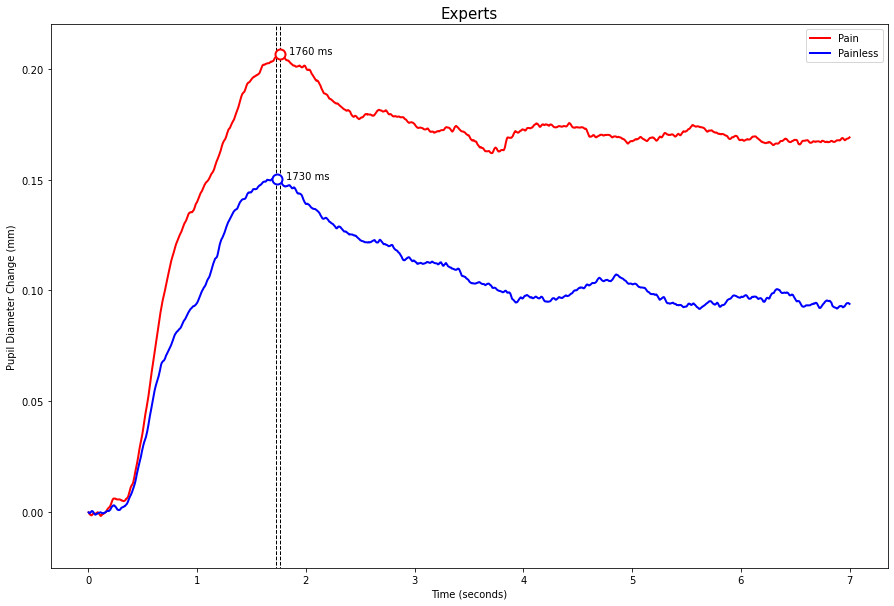

In [171]:
plt.figure(figsize=(15,10)) # Set plot area
x = list(range(1,len(e_p)+1)) # Set the abscissa axis
g = plt.plot(x,e_p,'r',linewidth = 2) # Print mean sign
g = plt.plot(x,e_pl,'b',linewidth = 2) # Print mean sign
g = plt.axvline(x = [np.argmax(e_p)], ymin = -0.025, ymax = 1, color = 'black', linestyle = '--', linewidth = 1)
g = plt.axvline(x = [np.argmax(e_pl)], ymin = -0.025, ymax = 1, color = 'black', linestyle = '--', linewidth = 1)
g = plt.text(x[np.argmax(e_p)]+25, e_p[np.argmax(e_p)], str(round(np.argmax(e_p)/300*1000))+str(' ms'), fontsize=10)
g = plt.text(x[np.argmax(e_pl)]+25, e_pl[np.argmax(e_pl)], str(round(np.argmax(e_pl)/300*1000))+str(' ms'), fontsize=10)
g = plt.plot(x[np.argmax(e_p)], e_p[np.argmax(e_p)], 'o', 
             markersize=10, markeredgecolor="red", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmax(e_pl)], e_pl[np.argmax(e_pl)], 'o',
             markersize=10, markeredgecolor="blue", markerfacecolor="white", markeredgewidth=2)
g = plt.ylim(-0.025, 0.22)
g = plt.legend(['Pain','Painless']) # Insert legend
g = plt.title("Experts", fontsize = 15) # Insert title
g = plt.ylabel('Pupil Diameter Change (mm)') # Insert label of the ordinate axis
g = plt.xlabel('Time (seconds)') # Insert label of the ordinate axis
g = plt.xticks(ticks=[0,300,600,900,1200,1500,1800,2100], labels=[0,1,2,3,4,5,6,7])


SyntaxError: keyword argument repeated: markersize (Temp/ipykernel_18008/3080892455.py, line 9)

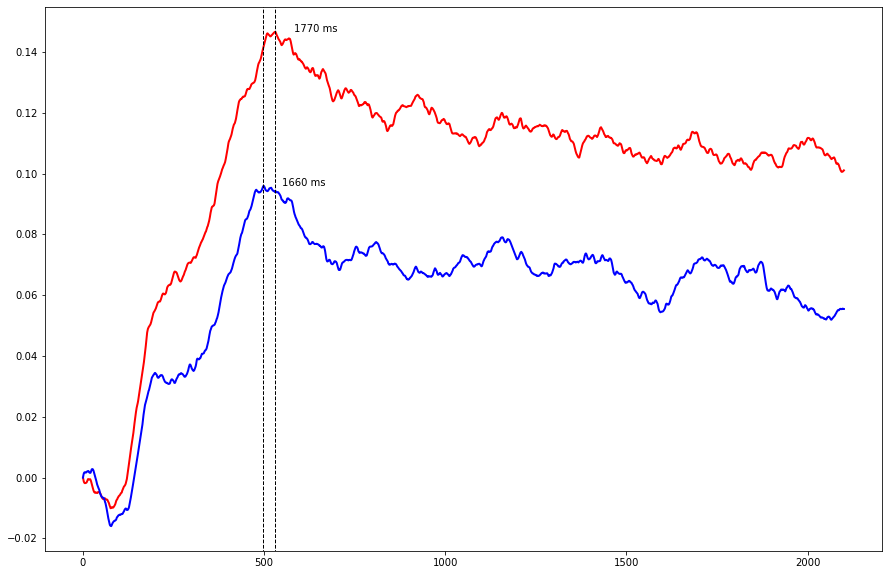

In [173]:
plt.figure(figsize=(15,10)) # Set plot area
x = list(range(1,len(p_p)+1)) # Set the abscissa axis
g = plt.plot(x,p_p,'r',linewidth = 2) # Print mean sign
g = plt.plot(x,p_pl,'b',linewidth = 2) # Print mean sign
g = plt.axvline(x = [np.argmax(p_p)], ymin = -0.025, ymax = 1, color = 'black', linestyle = '--', linewidth = 1)
g = plt.axvline(x = [np.argmax(p_pl)], ymin = -0.025, ymax = 1, color = 'black', linestyle = '--', linewidth = 1)
g = plt.text(x[np.argmax(p_p)]+50, p_p[np.argmax(p_p)], str(round(np.argmax(p_p)/300*1000))+str(' ms'), fontsize=10)
g = plt.text(x[np.argmax(p_pl)]+50, p_pl[np.argmax(p_pl)], str(round(np.argmax(p_pl)/300*1000))+str(' ms'), fontsize=10)
g = plt.plot(x[np.argmax(p_p)], p_p[np.argmax(p_p)], 'o',markersize=10, 
             markersize=10, markeredgecolor="red", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmax(p_pl)], p_pl[np.argmax(p_pl)], 'o', 
             markersize=10, markeredgecolor="blue", markerfacecolor="white", markeredgewidth=2)
g = plt.ylim(-0.025, 0.22)
g = plt.legend(['Pain','Painless']) # Insert legend
g = plt.title("Parents", fontsize = 15) # Insert title
g = plt.xlabel('Time (seconds)') # Insert label of the ordinate axis
g = plt.xticks(ticks=[0,300,600,900,1200,1500,1800,2100], labels=[0,1,2,3,4,5,6,7])

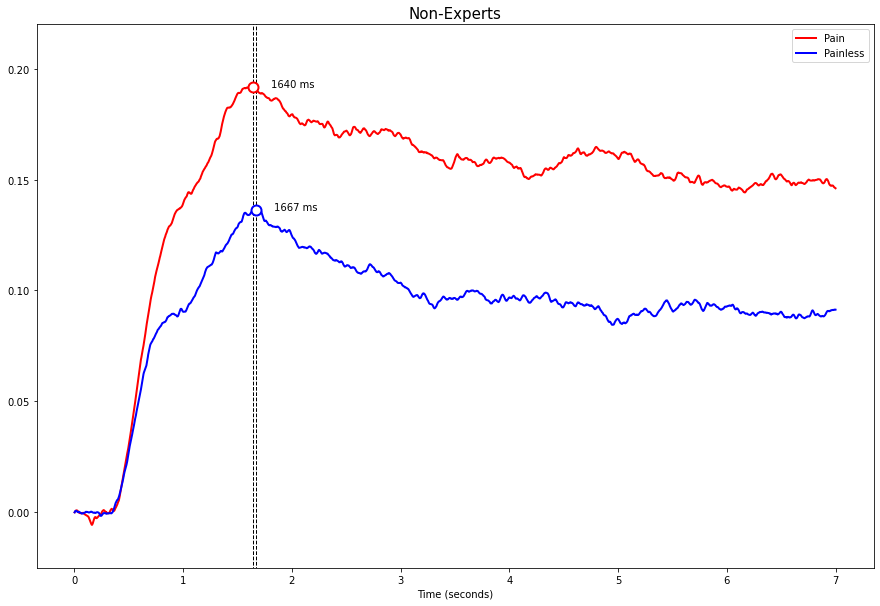

In [174]:
plt.figure(figsize=(15,10)) # Set plot area
x = list(range(1,len(n_p)+1)) # Set the abscissa axis
g = plt.plot(x,n_p,'r', linewidth = 2) # Print mean sign
g = plt.plot(x,n_pl,'b', linewidth = 2) # Print mean sign
g = plt.axvline(x = [np.argmax(n_p)], ymin = -0.025, ymax = 1, color = 'black', linestyle = '--', linewidth = 1)
g = plt.axvline(x = [np.argmax(n_pl)], ymin = -0.025, ymax = 1, color = 'black', linestyle = '--', linewidth = 1)
g = plt.text(x[np.argmax(n_p)]+50, n_p[np.argmax(n_p)], str(round(np.argmax(n_p)/300*1000))+str(' ms'), fontsize=10)
g = plt.text(x[np.argmax(n_pl)]+50, n_pl[np.argmax(n_pl)], str(round(np.argmax(n_pl)/300*1000))+str(' ms'), fontsize=10)
g = plt.plot(x[np.argmax(n_p)], n_p[np.argmax(n_p)], 'o',
             markersize=10, markeredgecolor="red", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmax(n_pl)], n_pl[np.argmax(n_pl)], 'o', 
             markersize=10, markeredgecolor="blue", markerfacecolor="white", markeredgewidth=2)
g = plt.ylim(-0.025, 0.22)
g = plt.legend(['Pain','Painless']) # Insert legend
g = plt.title("Non-Experts", fontsize = 15) # Insert title
g = plt.xlabel('Time (seconds)') # Insert label of the ordinate axis
g = plt.xticks(ticks=[0,300,600,900,1200,1500,1800,2100], labels=[0,1,2,3,4,5,6,7])